In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.utils import np_utils

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
def k_fold(x,y):
    kf = KFold(n_splits = 10, shuffle = True)
    for train_index, test_index in kf.split(x):
    
        x_train, x_test = x[train_index], x[test_index] 
        y_train, y_test = y[train_index], y[test_index]

    return x_train, x_test,y_train,y_test

In [7]:
def create_custom_model (n=1, name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(n):
            model.add(Dense(50, input_dim=4, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
            model.add(Dropout(0.3))
            model.add(Dense(30, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
            model.add(Dropout(0.3))
            model.add(Dense(10, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
            model.add(Dropout(0.3))
            model.add(Dense(6,activation='softmax'))
        
        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

In [8]:
df= pd.read_csv("result.csv")

In [9]:
x = df.copy()
y= x.pop("clusters_pred")
train_stats = x.describe()
train_stats = train_stats.transpose()

In [10]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [11]:
x_train, x_test, y_train, y_test = k_fold(x_scaled, y)

In [12]:
y_train=np_utils.to_categorical(y_train,num_classes=6)
y_test=np_utils.to_categorical(y_test,num_classes=6)

In [13]:
models = [create_custom_model(i, 'model_{}'.format(i)) for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                250       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 66  

In [14]:
history_dict = {}
for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    plot = model.fit(x_train, y_train, epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    history_dict[model.name] = [plot, model]

Model name: model_1

Epoch: 0, accuracy:0.8719,  loss:0.7872,  val_accuracy:0.1652,  val_loss:2.4131,  
..............................Test loss: 0.47842076420783997
Test accuracy: 0.8524759411811829
Model name: model_2

Epoch: 0, accuracy:0.8747,  loss:0.9044,  val_accuracy:0.1123,  val_loss:2.3428,  
.............................................Test loss: 0.4975593388080597
Test accuracy: 0.841471791267395
Model name: model_3

Epoch: 0, accuracy:0.7682,  loss:1.2147,  val_accuracy:0.0000,  val_loss:3.6117,  
.................Test loss: 1.3002698421478271
Test accuracy: 0.6344566941261292


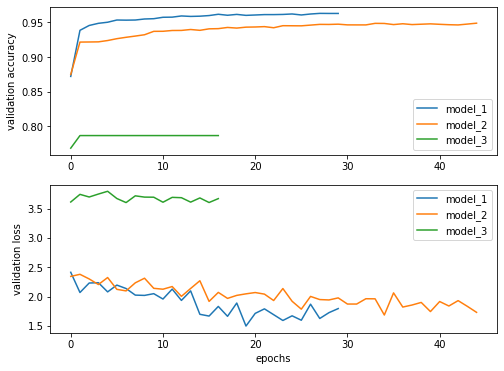

In [15]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_acc = history_dict[model_name][0].history['accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_acc, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend()
plt.show()

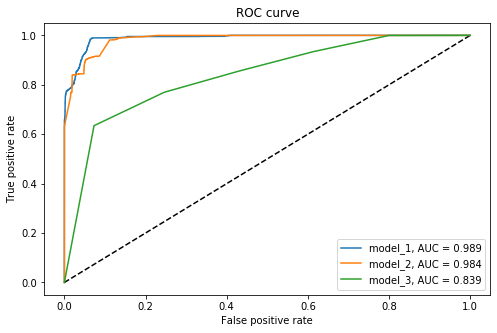

In [16]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--')

for model_name in history_dict:
    model = history_dict[model_name][1]
    
    y_pred = model.predict(x_test)
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())
    
    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(model_name, auc(fpr, tpr)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();